### Case Study number of blogposts

See: 
http://archive.ics.uci.edu/ml/datasets/BlogFeedback

As suggested in the paper and acomaning [talk](http://archive.ics.uci.edu/ml/datasets/BlogFeedback), we use only the base features

#### Results Hits@10 mean and stdderr


##### 20,5 with only base features
LR   5.483   0.181799  #<--- In the paper they had 5.450 +- 1.322 (whatever +- is)

Poisson 5.966 0.1763

ZI Poisson 6.0 0.15

##### 100,10 with only base features

LR               5.71 0.170

Poisson      6.10 0.179 

ZI Poisson 6.15 0.163

##### No Hidden with only base features
LR               4.45 0.15

Poisson     5.133 0.167442

ZI Poisson got NaNs


##### Some results using all features

##### On hidden layer with 10 nodes (all features)
LR                 4.900 0.1690

Poisson       5.483 0.1878

ZI Poisson  5.566 0.1515

##### Two hidden layer with 100, 10 nodes (all features)
LR               5.166666666666667 0.15664

Poisson     5.85 0.1868

Zi Poisson 5.666666666666667 0.18358568490

In [1]:
import os
if not os.path.isfile('blogdata/BlogFeedback.zip'):
    !mkdir blogdata
    print("Installing wget")
    !pip install wget
    import wget
    print("Downloading file")
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip', 'blogdata/BlogFeedback.zip')
    print("Unzipping content")
    !unzip blogdata/BlogFeedback.zip -d blogdata
else:
    print("File exists")

File exists


In [0]:
!pip install -q --upgrade tensorflow-gpu==2.0.0-alpha0
print('Installation of `tensorflow-gpu==2.0.0-alpha0` complete.')

In [3]:
 !pip install -q tfp-nightly
 print("Installation of `tfp-nightly` complete.")

Installation of `tfp-nightly` complete.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev
TF  Version 2.0.0-alpha0


In [3]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

In [5]:
IS_GAUSSIAN = False
IS_ZI = False
USE_BASE = True #Use only the Basic features (successfully in paper)

In [6]:
# Loading to the data
d = np.loadtxt("blogdata/blogData_train.csv", delimiter=',', dtype=np.float32)
if USE_BASE:
  Xu = d[:,0:63]
else:
  Xu = d[:,0:279]

y = d[:,280]
d.shape, Xu.shape, y.shape

((52397, 281), (52397, 63), (52397,))

In [7]:
Xmean = np.mean(Xu,axis=0)
Xsd = np.std(Xu,axis=0)
X = (Xu-Xmean)/(Xsd+1e-10)

In [8]:
# Xm = np.concatenate([np.ones((np.shape(X)[0],1), dtype=np.float32), X], axis=1)
# Xm.shape
# # Doing the fit 
# fit = tfp.glm.fit(
#     model_matrix=Xm,
#     response=y,
#     model=tfp.glm.Normal()
# )
# Not working due to problems with cholesky 

In [9]:
def check_performance(model):
  if IS_GAUSSIAN:
    model_mean = model
  else: 
    if IS_ZI:
      model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y_zi.mean())
    else:
      model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean())
  files = [f for f in os.listdir('blogdata/') if f.startswith('blogData_test')]
  hits_at10 = np.zeros(len(files))
  for i,f in enumerate(files):
      d = np.loadtxt("blogdata/"+f, delimiter=',', dtype=np.float32)
      #print("{}".format(i))
      Xtu = d[:,0:X.shape[1]]
      yt = d[:,280]
      Xt = (Xtu-Xmean) / (Xsd+1e-10)
      d.shape, Xtu.shape, yt.shape
      y_pred = model_mean.predict(Xt).flatten()
      idx_true = np.argsort(yt)[-10:]
      idx_pred = np.argsort(y_pred)[-10:] #The 10 higest
      hits_at10[i]=len(np.intersect1d(idx_true, idx_pred))
  print(np.mean(hits_at10), np.std(hits_at10)/np.sqrt(len(files)))
  return hits_at10


### Definition of a Poisson Model

In [10]:
# Definition of the custom parametrized distribution
def my_poiss(t):
    return tfd.Poisson(rate=t) #Equivalent to log_rate=t when using linear activation 
  
## Definition of the model
#Using the functional API for clarity
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
rate = tf.keras.layers.Dense(100, activation='sigmoid')(inputs)
rate = tf.keras.layers.Dense(10, activation='sigmoid')(rate)
rate = tf.keras.layers.Dense(1, 
                             activation=tf.exp, 
                             bias_initializer='zeros', 
                             kernel_initializer='zeros')(rate)
p_y = tfp.layers.DistributionLambda(my_poiss)(rate) #<------- Here we hand-in the the custom distribution
#Glueing input and output together. Note that output is a tf.distirbution 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)

### Definition of a Gaussian Model

Using Poisson
Train on 47157 samples, validate on 5240 samples
Epoch 1/15
47157/47157 [==============================] - 2s 35us/sample - loss: 12.2278 - val_loss: 4.0224
Epoch 2/15
47157/47157 [==============================] - 1s 31us/sample - loss: 7.2314 - val_loss: 3.7967
Epoch 3/15
47157/47157 [==============================] - 1s 30us/sample - loss: 6.7398 - val_loss: 3.6832
Epoch 4/15
47157/47157 [==============================] - 1s 31us/sample - loss: 6.4533 - val_loss: 3.6235
Epoch 5/15
47157/47157 [==============================] - 1s 30us/sample - loss: 6.2701 - val_loss: 3.5859
Epoch 6/15
47157/47157 [==============================] - 1s 31us/sample - loss: 6.1389 - val_loss: 3.5362
Epoch 7/15
47157/47157 [==============================] - 1s 31us/sample - loss: 5.9799 - val_loss: 3.4974
Epoch 8/15
47157/47157 [==============================] - 1s 31us/sample - loss: 5.9405 - val_loss: 3.3824
Epoch 9/15
47157/47157 [==============================] - 2s 33us/sample - loss:

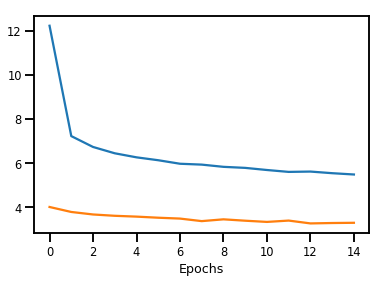

In [11]:
def negloglik(y_true, y_hat):
  return -y_hat.log_prob(y_true)

if IS_GAUSSIAN: #Using MSE
  model = tf.keras.models.Model(inputs=inputs, outputs=rate)
  model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
  print("Using Gaussian")
else:
  print("Using Poisson")
  model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)

if not IS_ZI:  
  hist = model.fit(X, y, epochs=15, verbose=1, validation_split=0.1);
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.xlabel('Epochs')
  np.mean(hist.history['loss'])

In [12]:
check_performance(model);
IS_ZI, IS_GAUSSIAN
model.summary()

6.016666666666667 0.16913450706902328
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 63)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               6400      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 7,421
Trainable params: 7,421
Non-trainable params: 0
_________________________________________________________________


### Definition of a zero inflated  Model

In [0]:
## Definition of the custom parametrized distribution
def my_zero(t):
    mean = tf.exp(t[:,0]) #Needed so that Poisson has batch_shape=(5,) 
    #print(mean)
    s = tf.math.sigmoid(t[...,1:])
    probs = tf.concat([s, 1-s], axis=1)
    #print(probs)
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#batch_shape=(5,) event_shape=()
          components=[
            tfd.Poisson(rate=mean),   #batch_shape=(5,) event_shape=()
            tfd.Deterministic(loc=tf.zeros_like(mean))
        ])


## Definition of the model
#Using the functional API for clarity
inputs = tf.keras.layers.Input(shape=(X.shape[1],))

# The mean path
m_h1 = tf.keras.layers.Dense(100, activation='sigmoid')(inputs)
m_h2 = tf.keras.layers.Dense(10, activation='sigmoid')(m_h1)
mean = tf.keras.layers.Dense(1,bias_initializer='zeros', kernel_initializer='zeros')(m_h2)

# The zero path
z_h1 = tf.keras.layers.Dense(100, activation='sigmoid')(inputs)
z_h2 = tf.keras.layers.Dense(10, activation='sigmoid')(z_h1)
z = tf.keras.layers.Dense(1,bias_initializer='zeros', kernel_initializer='zeros')(z_h2)

tt = tf.concat([mean, z], axis=1)
p_y_zi = tfp.layers.DistributionLambda(my_zero)(tt)

#Glueing input and output together. Note that output is a tf.distirbution 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y_zi)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 63)]         0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 100)          6400        input_3[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 100)          6400        input_3[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 10)           1010        dense_9[0][0]                    
____________________________________________________________________________________________

Train on 47157 samples, validate on 5240 samples
Epoch 1/15
47157/47157 [==============================] - 6s 126us/sample - loss: 10.4758 - val_loss: 2.4773
Epoch 2/15
47157/47157 [==============================] - 6s 118us/sample - loss: 5.8699 - val_loss: 2.3869
Epoch 3/15
47157/47157 [==============================] - 6s 119us/sample - loss: 5.5113 - val_loss: 2.2247
Epoch 4/15
47157/47157 [==============================] - 6s 119us/sample - loss: 5.3284 - val_loss: 2.3180
Epoch 5/15
47157/47157 [==============================] - 6s 118us/sample - loss: 5.2414 - val_loss: 2.3293
Epoch 6/15
47157/47157 [==============================] - 7s 142us/sample - loss: 5.1443 - val_loss: 2.1886
Epoch 7/15
47157/47157 [==============================] - 7s 139us/sample - loss: 5.0717 - val_loss: 2.2796
Epoch 8/15
47157/47157 [==============================] - 6s 119us/sample - loss: 5.0346 - val_loss: 2.3517
Epoch 9/15
47157/47157 [==============================] - 6s 119us/sample - loss: 4.98

5.453362395166454

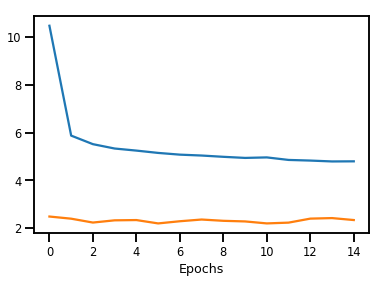

In [0]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))
  
  
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
hist = model.fit(X, y, epochs=15, verbose=1, validation_split=0.1);

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
np.mean(hist.history['loss'])

In [0]:
check_performance(model_mean);
IS_ZI, IS_GAUSSIAN
model_mean.summary()

5.9 0.16782927833565472
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 63)]              0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               6400      
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
_________________________________________________________________
distribution_lambda_3/Poisso [(None, 1)]               0         
_________________________________________________________________
Identity_8 (TensorFlowOpLaye [(None, 1)]               0         
Total params: 7,421
Trainable params: 7,421
Non-trainable params: 0
_________________________________